## Ariadna González de Prado


# Imports

Importo las librerías necesarias y los datos tratados anteriormente

In [1]:
#pip install imbalanced-learn
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas import Series
import datetime

import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc


pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_excel('base_datos_vinos.xlsx')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data=data.drop(['WB'],axis=1)
data=data.drop(['DP'],axis=1)
data = data.dropna()
data.head()

,TEMP MED,TEMP MAX,TEMP MIN,HUM MED,HUM MAX,HUM MIN,viento,dirección viento,viento max,Radiación,Precipitación,Date,mildiu
0,6.87,15.66,-0.47,82.2,100.0,47.19,0.29,41.05,2.09,5.82,0.00,2017-11-01,0.0
1,11.15,15.01,8.76,93.2,100.0,75.60,0.40,90.50,2.56,1.72,2.56,2017-11-02,0.0
2,11.51,15.26,9.16,96.0,100.0,70.80,0.33,259.30,2.25,3.96,2.36,2017-11-03,0.0
3,12.28,17.32,9.76,86.6,100.0,64.72,1.11,283.10,5.95,5.54,0.59,2017-11-04,0.0
4,9.26,13.94,4.50,74.8,98.1,54.79,1.50,271.80,5.28,7.92,0.00,2017-11-05,0.0


In [3]:
data.info()
print(data.index.dtype)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2014
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   TEMP MED          1975 non-null   float64       
 1   TEMP MAX          1975 non-null   float64       
 2   TEMP MIN          1975 non-null   float64       
 3   HUM MED           1975 non-null   float64       
 4   HUM MAX           1975 non-null   float64       
 5   HUM MIN           1975 non-null   float64       
 6   viento            1975 non-null   float64       
 7   dirección viento  1975 non-null   float64       
 8   viento max        1975 non-null   float64       
 9   Radiación         1975 non-null   float64       
 10  Precipitación     1975 non-null   float64       
 11  Date              1975 non-null   datetime64[ns]
 12  mildiu            1975 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 216.0 KB
int64


# Análisis de datos

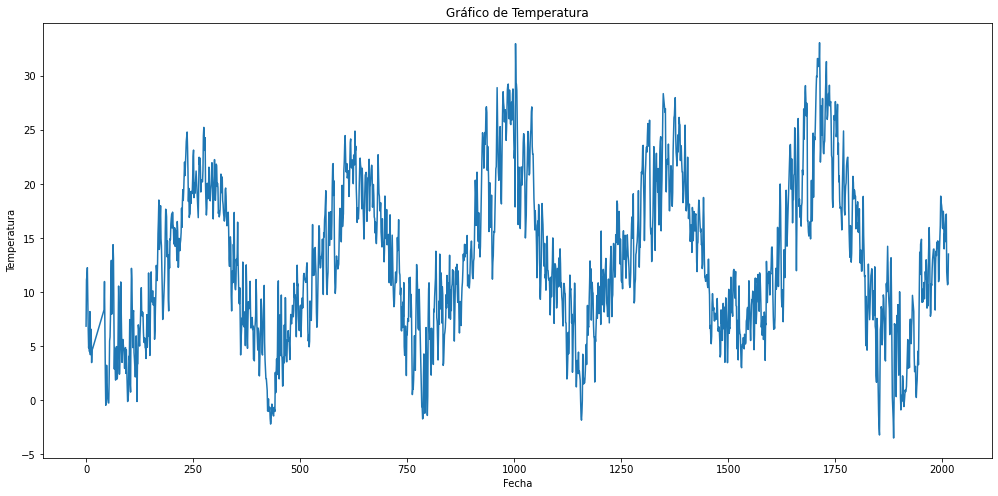

In [4]:
#Mostrar la temeratura segun su cronología
plt.figure(figsize=(17, 8))
data['TEMP MED'].plot()
plt.title('Gráfico de Temperatura')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')

# Mostrar el gráfico
plt.show()

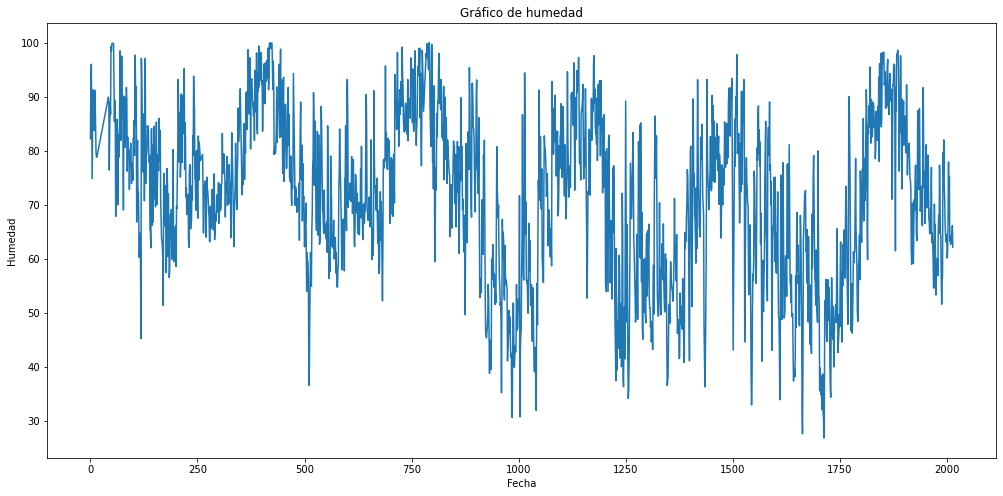

In [5]:
#Mostrar la humedad segun su cronología
plt.figure(figsize=(17, 8))
data['HUM MED'].plot()
plt.title('Gráfico de humedad')
plt.xlabel('Fecha')
plt.ylabel('Humedad')

# Mostrar el gráfico
plt.show()

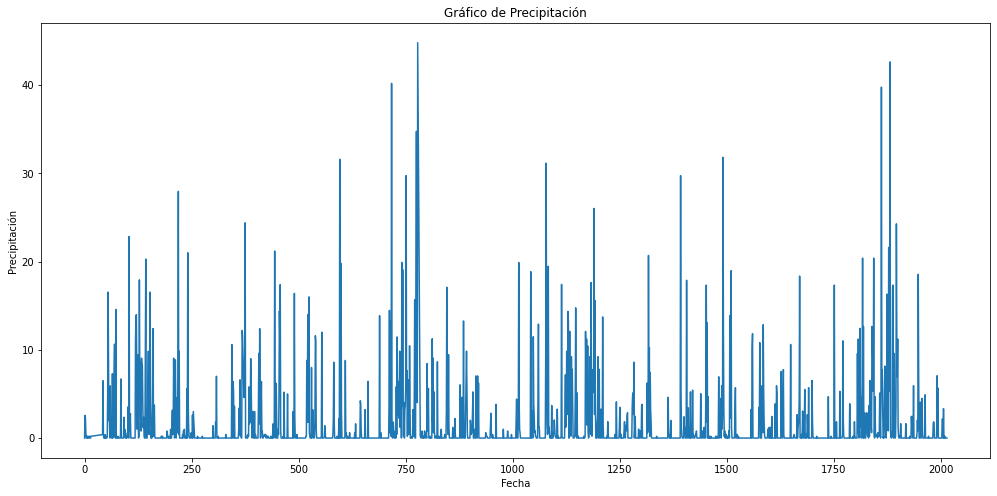

In [6]:
#Mostrar la precipitacón segun su cronología
plt.figure(figsize=(17, 8))
data['Precipitación'].plot()
plt.title('Gráfico de Precipitación')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')

# Mostrar el gráfico
plt.show()

<Figure size 1224x576 with 0 Axes>

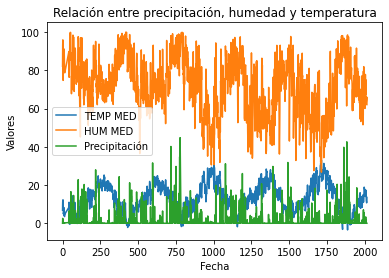

In [7]:
#Mostrar humedad, temperatura y precipitación en la misma grafica para mostrar su relación según el orden cronológico
plt.figure(figsize=(17, 8))
data[['TEMP MED', 'HUM MED', 'Precipitación']].plot()

plt.title('Relación entre precipitación, humedad y temperatura')
plt.xlabel('Fecha')
plt.ylabel('Valores')

# Mostrar el gráfico
plt.show()


# Obtener DB ampliada según tabla Goidanich

A partir de la primera aparición de los síntomas constatada en los datos aportados por la bodega con un 1, vamos a aplicar una serie de filtros a los datos para establecer el crecimiento de la planta según la tabla de Goidanich modificada para nuestra zona geográfica.
De esta forma obtendremos más información sobre la aparación del mildiu en los viñedos y podremos predecir mejor su posterior aparición.

Tener en cuenta para el TFG -> que cuando ya se presentan los síntomas (asumimos que ya lo tenemos, es el 1) es porque ... reglas de los 3 dieces.
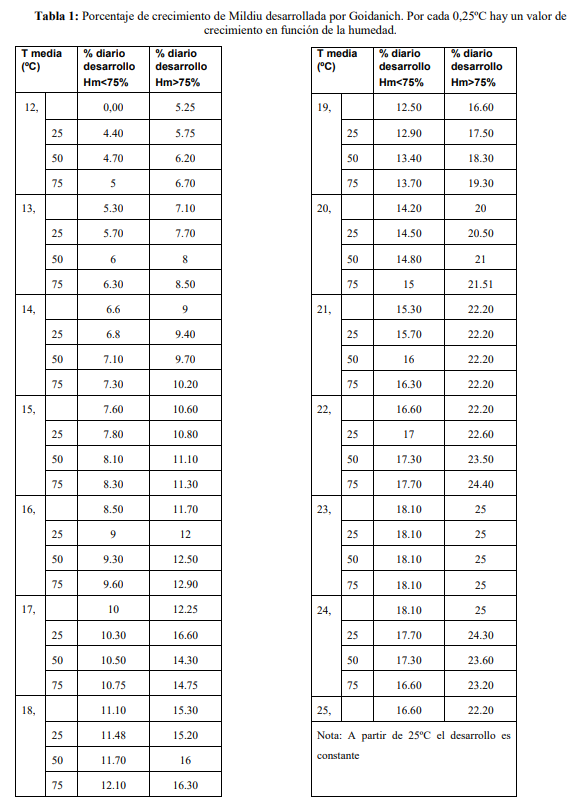

In [8]:
#añado una columna de todo ceros
data['crecimiento']=0
data['mildiu'] = data['mildiu'].astype(int)
data.reset_index(drop=True, inplace=True)
data.head()

,TEMP MED,TEMP MAX,TEMP MIN,HUM MED,HUM MAX,HUM MIN,viento,dirección viento,viento max,Radiación,Precipitación,Date,mildiu,crecimiento
0,6.87,15.66,-0.47,82.2,100.0,47.19,0.29,41.05,2.09,5.82,0.00,2017-11-01,0,0
1,11.15,15.01,8.76,93.2,100.0,75.60,0.40,90.50,2.56,1.72,2.56,2017-11-02,0,0
2,11.51,15.26,9.16,96.0,100.0,70.80,0.33,259.30,2.25,3.96,2.36,2017-11-03,0,0
3,12.28,17.32,9.76,86.6,100.0,64.72,1.11,283.10,5.95,5.54,0.59,2017-11-04,0,0
4,9.26,13.94,4.50,74.8,98.1,54.79,1.50,271.80,5.28,7.92,0.00,2017-11-05,0,0


In [9]:
tabla_goidanich = pd.read_excel('tabla_goidanich.xlsx')
tabla_goidanich=tabla_goidanich.set_index('Temperatura')
tabla_goidanich.head()

,Hum <75,Hum >75
Temperatura,,
10.00,0.0,3.5
10.25,2.3,3.8
10.50,2.6,4.1
10.75,2.8,4.2
11.00,3.0,4.4


In [10]:
def redondear_valor(numero):
    base = int(numero)  # Extraer la parte entera del número
    decimal = numero - base  # Extraer la parte decimal del número
    
    if decimal <= 0.125:
        decimal_redondeado = 0
    elif decimal <= 0.375:
        decimal_redondeado = 0.25
    elif decimal <= 0.625:
        decimal_redondeado = 0.5
    elif decimal <= 0.875:
        decimal_redondeado = 0.75
    else:
        decimal_redondeado = 1
    
    numero_redondeado = base + decimal_redondeado
    
    return numero_redondeado

In [11]:
data_ampliada=data.copy()
len(data_ampliada)

1975

In [12]:
i = 0
while i < len(data_ampliada):
    if data_ampliada['mildiu'][i] == 1:
        for j in range(i+1,len(data_ampliada)):
            temp = data_ampliada.loc[j, 'TEMP MED']
            hum = data_ampliada.loc[j, 'HUM MED']
            i = j   # avanzar al siguiente índic
            if temp >= 10:
                temp_redondeada = redondear_valor(temp)
                if temp_redondeada > 25:
                    temp_redondeada = 25
                if hum <= 75:
                    data_ampliada.loc[j, 'crecimiento'] = data_ampliada.loc[j-1, 'crecimiento'] + tabla_goidanich.loc[temp_redondeada, 'Hum <75']
                else:
                    data_ampliada.loc[j, 'crecimiento'] = data_ampliada.loc[j-1, 'crecimiento'] + tabla_goidanich.loc[temp_redondeada, 'Hum >75']
                
                if data_ampliada.loc[j, 'crecimiento'] >= 100:
                    data_ampliada.loc[j, 'mildiu'] = 1
                    data_ampliada.loc[j, 'crecimiento'] = 0
                    break
            
            else:
                i=j+1
                break
    else:
        i += 1
    


In [13]:
data_ampliada.to_excel('data_ampliada.xlsx', index=False)

# Obtener DB para la aplicación del modelo

Para la aplicación del modelo teniendo en cuenta las serie temporal determinada en el índice, es necesario añadir las características de esta serie temporal como columnas de la BD en vez de estar represenada uúnicamente en el indice.

Esto quiere decir añadir un columna para el día, mes y año en el que estamos; de esta forma estos datos también se tendrá en cuenta para la predicción de la enfermedad.

In [14]:
data_plus=data_ampliada.copy()
data_plus=data_plus.set_index('Date')
data_plus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1975 entries, 2017-11-01 to 2023-05-14
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TEMP MED          1975 non-null   float64
 1   TEMP MAX          1975 non-null   float64
 2   TEMP MIN          1975 non-null   float64
 3   HUM MED           1975 non-null   float64
 4   HUM MAX           1975 non-null   float64
 5   HUM MIN           1975 non-null   float64
 6   viento            1975 non-null   float64
 7   dirección viento  1975 non-null   float64
 8   viento max        1975 non-null   float64
 9   Radiación         1975 non-null   float64
 10  Precipitación     1975 non-null   float64
 11  mildiu            1975 non-null   int32  
 12  crecimiento       1975 non-null   float64
dtypes: float64(12), int32(1)
memory usage: 208.3 KB


In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df


In [16]:
data_plus=create_features(data_plus)

In [17]:
data_plus.to_excel('data_plus.xlsx', index=False)

# Visualización de datos y su relación

In [18]:
data_plus

,TEMP MED,TEMP MAX,TEMP MIN,HUM MED,HUM MAX,HUM MIN,viento,dirección viento,viento max,Radiación,Precipitación,mildiu,crecimiento,dayofweek,quarter,month,year,dayofyear,dayofmonth
Date,,,,,,,,,,,,,,,,,,,
2017-11-01,6.87,15.66,-0.47,82.20,100.0,47.19,0.29,41.05,2.09,5.82,0.00,0,0.0,2,4,11,2017,305,1
2017-11-02,11.15,15.01,8.76,93.20,100.0,75.60,0.40,90.50,2.56,1.72,2.56,0,0.0,3,4,11,2017,306,2
2017-11-03,11.51,15.26,9.16,96.00,100.0,70.80,0.33,259.30,2.25,3.96,2.36,0,0.0,4,4,11,2017,307,3
2017-11-04,12.28,17.32,9.76,86.60,100.0,64.72,1.11,283.10,5.95,5.54,0.59,0,0.0,5,4,11,2017,308,4
2017-11-05,9.26,13.94,4.50,74.80,98.1,54.79,1.50,271.80,5.28,7.92,0.00,0,0.0,6,4,11,2017,309,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10,11.91,19.17,1.52,63.24,93.7,38.05,1.40,299.40,6.08,23.86,0.00,0,60.3,2,2,5,2023,130,10
2023-05-11,11.14,18.37,1.92,64.02,93.1,36.53,1.21,317.60,6.75,20.60,0.00,0,63.6,3,2,5,2023,131,11
2023-05-12,10.70,18.26,2.78,64.75,92.9,38.33,1.27,346.40,5.75,17.29,0.00,0,66.4,4,2,5,2023,132,12


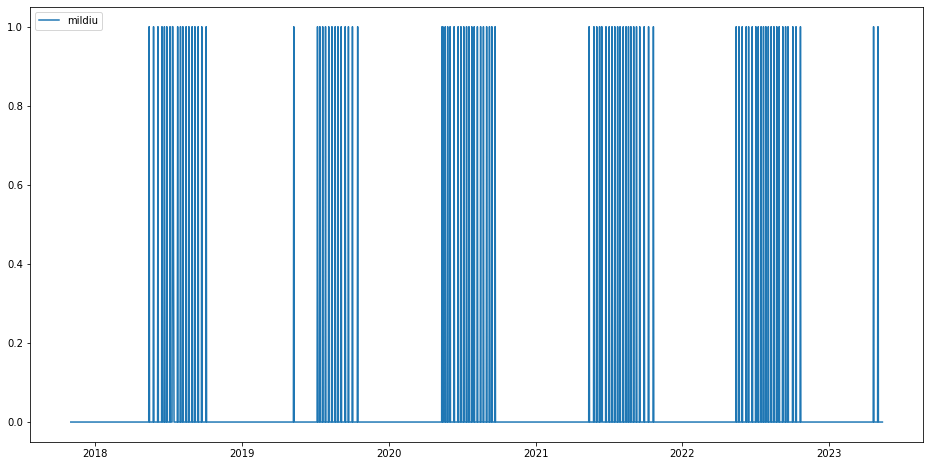

In [19]:
x=data_plus['mildiu']
plt.figure(figsize=(16,8))
plt.plot(x,linestyle="-",label='mildiu')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

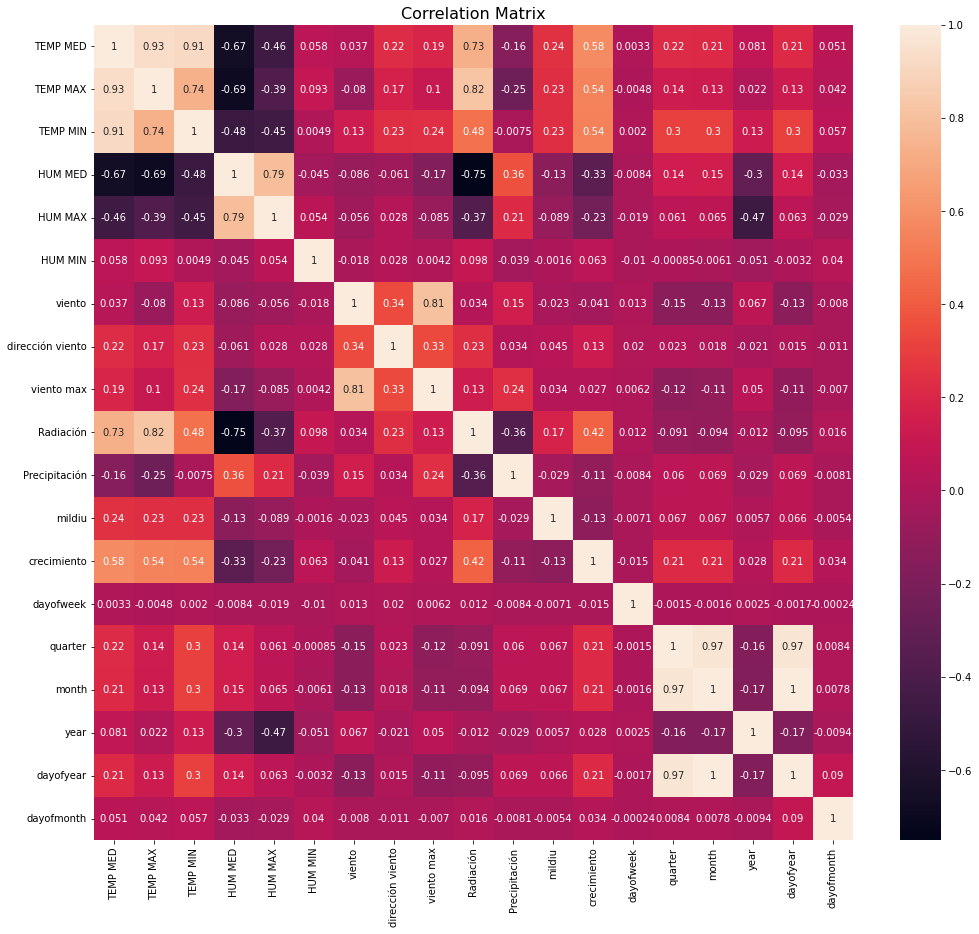

In [20]:
#Matriz de confusión
f = plt.figure(figsize=(17, 15))
plt.title('Correlation Matrix', fontsize=16);
#Uso la función de la librería seaborn para presentar el heatmap y la matriz de correlación
sns.heatmap(data_plus.corr(), 
        xticklabels=data_plus.corr().columns,
        yticklabels=data_plus.corr().columns,annot=True)

# MODELO
Primero voy a extraer información sobre los datos que quiero predecir, la columna mildiu.

¿Cómo elegir entre regresión y clasificación binaria?

He elegido clasificación binaria debido a..

1) Naturaleza de los datos: Si la columna binaria que estás tratando de predecir está basada en umbrales o criterios específicos (por ejemplo, si los síntomas están presentes si una cierta temperatura se supera), entonces la clasificación binaria puede ser más adecuada. La clasificación binaria te ayudará a asignar observaciones a categorías discretas y a tomar decisiones basadas en umbrales establecidos.

2) Aplicabilidad clínica: Considera la aplicabilidad de los resultados en el contexto clínico. Si estás trabajando en un entorno médico donde la detección temprana de los síntomas de una enfermedad es crucial, la clasificación binaria podría ser más relevante

Además, el orden cronológico del índice del dataframe sugiere que estás tratando con una secuencia de observaciones en el tiempo. La clasificación binaria te ayudará a modelar y predecir los cambios en la presencia de síntomas a lo largo del tiempo.

Puedes utilizar algoritmos de clasificación binaria, como XGBoost, para entrenar un modelo en tus datos y realizar predicciones sobre la aparición de síntomas en función de los datos climatológicos diarios. 

In [21]:
contador = data_plus['mildiu'].value_counts()
print(contador)

porcentaje_mildiu=contador[1]*100/(contador[1]+contador[0])
print('El porcentaje de mildiu es: ',porcentaje_mildiu)


0    1876
1      99
Name: mildiu, dtype: int64
El porcentaje de mildiu es:  5.012658227848101


### Equilibrar datos

Dado que el conjunto de datos está desequilibrado, donde la columna mildiu tiene un 95% de ceros y un 5% de unos, aplicaremos técnicas de balanceo para igualar la proporción de ambos casos. Asignando pesos a las diferentes clases durante el entrenamiento. Asignar un peso mayor a la clase de unos para que el modelo se enfoque en mejorar la predicción de esta clase. Esto se logra ajustando el parámetro scale_pos_weight en la configuración del modelo.


### Divido los datos

In [22]:
X = data_plus.drop('mildiu', axis=1)  # Variables predictoras
y = data_plus['mildiu']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## MODELO REGRESION LINEAL

In [23]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 0.19


## MODELO RANDOM FOREST

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.07


In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.08


## MODELOS clasificación

### MODELO 2

In [30]:
# Creo un objeto DMatrix
#XGBoost requiere que los datos estén en un formato específico
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [33]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight':0.96  # Proporción de la clase mayoritaria a la clase minoritaria
}

#Entreno el modelo
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

#Obtengo las predicciones
y_pred = model.predict(dtest)
y_pred =  [1 if pred >= 0.5 else 0 for pred in y_pred]

score = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')

print(classification_report(y_test, y_pred))

RMSE Score on Test set: 0.08
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       282
           1       1.00      0.87      0.93        15

    accuracy                           0.99       297
   macro avg       1.00      0.93      0.96       297
weighted avg       0.99      0.99      0.99       297



### MODELO 3

In [34]:
from xgboost.sklearn import XGBClassifier
# Creo un clasificador usandoXGBoost
classifier = XGBClassifier(scale_pos_weight=0.95)

# Entreno el classifier, para obtener mis resultados deseados
classifier.fit(X_train, y_train)

#Una vez entrenado el clasificar, lo pruebo con mi data set test, usando X_test para predecir y_test
prediction = classifier.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      0.93      0.97        15

    accuracy                           1.00       297
   macro avg       1.00      0.97      0.98       297
weighted avg       1.00      1.00      1.00       297



In [35]:
score = np.sqrt(mean_squared_error(y_test, prediction))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 0.06


Un RMSE Score de 0.06 significa que, en promedio, las predicciones del modelo difieren en 0.006 unidades de los valores reales en el conjunto de prueba. Cuanto más bajo sea el valor del RMSE, mejor será la precisión del modelo, ya que indica una menor diferencia entre las predicciones y los valores reales.

In [36]:
from sklearn.metrics import r2_score
print(r2_score(list(y_test),list(prediction)))

0.9297872340425531


Si el r2_score (coeficiente de determinación) refleja un valor alto (dado que este dato es un número entre 0 y 1), indica que el modelo es capaz de explicar una gran parte de la variabilidad de los datos.

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Crear el objeto de validación cruzada (KFold con 5 particiones)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar la validación cruzada y obtener las puntuaciones de rendimiento
puntuaciones = cross_val_score(classifier, X, y, cv=kf, scoring='r2')

# Imprimir las puntuaciones de rendimiento para cada iteración de validación cruzada
for i, puntuacion in enumerate(puntuaciones):
    print(f'Iteración {i+1}: R2 Score = {puntuacion:.4f}')


Iteración 1: R2 Score = 0.8075
Iteración 2: R2 Score = 0.4816
Iteración 3: R2 Score = 0.5324
Iteración 4: R2 Score = 0.6820
Iteración 5: R2 Score = 0.8292


Los resultados que obtienes en cada iteración de la validación cruzada indican el rendimiento de tu modelo de machine learning en diferentes conjuntos de prueba. En este caso, estás utilizando el coeficiente de determinación R2 como métrica de rendimiento.

El coeficiente de determinación R2 varía entre 0 y 1, donde un valor más cercano a 1 indica un mejor ajuste del modelo a los datos. Aquí está la interpretación de los resultados que has obtenido:

- Iteración 5: R2 Score = 0.8292: En esta iteración, el modelo logró un R2_score de 0.8292, lo que indica que puede explicar aproximadamente el 82.92% de la variabilidad de los datos. Este valor es el más alto de todos, lo que sugiere un ajuste muy bueno del modelo a los datos.

En resumen, aunque los valores de R2_score varían en cada iteración de la validación cruzada, en general, el modelo muestra cierta capacidad para ajustarse a los datos en todas las iteraciones. 

In [55]:
# Realizar la validación cruzada y obtener las puntuaciones de rendimiento
puntuations = cross_val_score(classifier, X, y, cv=kf, scoring='roc_auc')

# Imprimir las puntuaciones de rendimiento para cada iteración de validación cruzada
for i, puntuacion in enumerate(puntuations):
    print(f'Iteración {i+1}: AUC-ROC Score = {puntuacion:.4f}')


Iteración 1: AUC-ROC Score = 0.9937
Iteración 2: AUC-ROC Score = 0.9248
Iteración 3: AUC-ROC Score = 0.9356
Iteración 4: AUC-ROC Score = 0.9648
Iteración 5: AUC-ROC Score = 0.9984


Los resultados obtenidos en cada iteración de la validación cruzada utilizando el área bajo la curva ROC (AUC-ROC) como métrica de rendimiento indican la capacidad de discriminación del modelo de machine learning en diferentes conjuntos de prueba. En general, un valor más cercano a 1 indica un mejor rendimiento del modelo en términos de clasificación.

Aquí está la interpretación de los resultados que has obtenido:

- Iteración 5: AUC-ROC Score = 0.9984: En esta iteración, el modelo logró un AUC-ROC Score de 0.9984, lo que indica una capacidad de discriminación casi perfecta. El modelo es capaz de distinguir entre las clases con una precisión excepcionalmente alta.

En resumen, los resultados obtenidos en todas las iteraciones de la validación cruzada indican que el modelo tiene una capacidad de discriminación sólida y puede distinguir con precisión entre las clases positiva y negativa en los conjuntos de prueba.

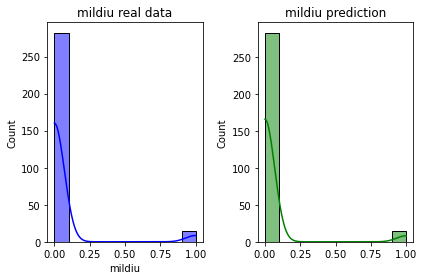

In [37]:
#Muestro los plots referentes al valor esperado de mildiu y su predicción por parte del modelo
plt.subplot(1,2,1)
sns.histplot(data=y_test, color='blue', kde=True,label='y_test')
plt.title('mildiu real data', fontsize=12)

plt.subplot(1,2,2) 
sns.histplot(data=prediction,color='green', kde=True,label='prediction')
plt.title('mildiu prediction', fontsize=12)

plt.tight_layout() 
plt.show() 

# Explainability and interpretability of Machine Learning: SHAP Library


In [38]:
import shap
#Primeramente creo el Explainer con el primer modelo realizado
explainer=shap.Explainer(classifier,X_test)

# Calculo SHAP values
shap_values = explainer(X_test)

In [69]:
import random
lista=[]
for i in range(len(data_ampliada)):
    if data_ampliada['mildiu'][i] == 1:
        lista.append(i)

index=random.choice(lista)
index2=random.choice(lista)
index3=random.choice(lista)
shap_values[index]

.values =
array([-1.340148  , -0.26958785, -0.40862815,  0.02976248, -0.46538454,
        0.0266567 , -0.27042281,  0.11720563,  0.08171452, -0.67173215,
        0.26274151,  1.83366589, -0.01800081,  0.0072299 ,  0.        ,
        0.50746337, -0.12107361,  0.18672435])

.base_values =
-7.2954632624611255

.data =
array([1.015e+01, 1.706e+01, 4.440e+00, 8.820e+01, 9.790e+01, 6.460e+01,
       7.100e-01, 3.144e+02, 4.960e+00, 5.930e+00, 1.265e+01, 0.000e+00,
       6.000e+00, 4.000e+00, 1.100e+01, 2.022e+03, 3.240e+02, 2.000e+01])

### WATERFALL PLOT

941


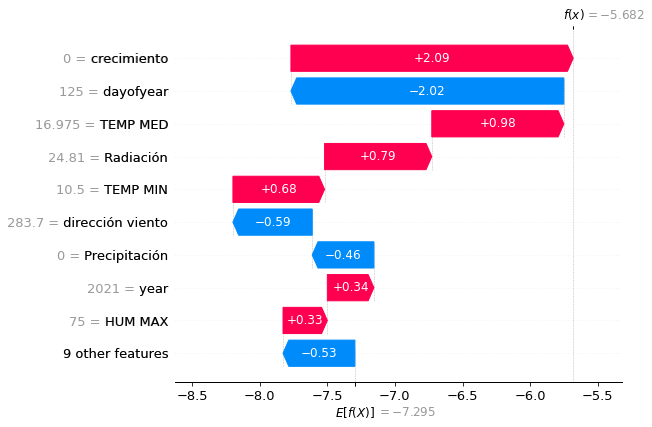

In [63]:
print(index)
shap.plots.waterfall(shap_values[index])

1393


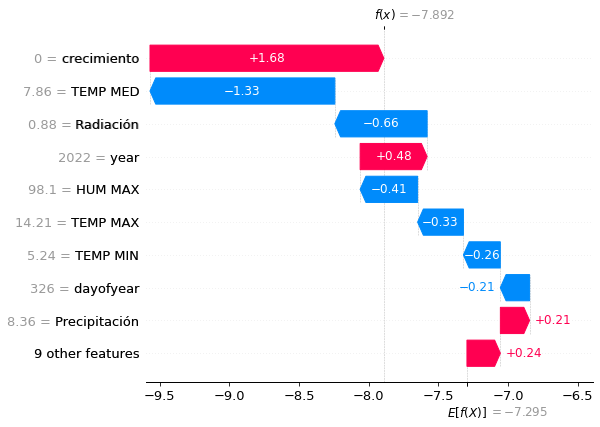

In [68]:
#Waterfall
print(index2)
shap.plots.waterfall(shap_values[index2])

888


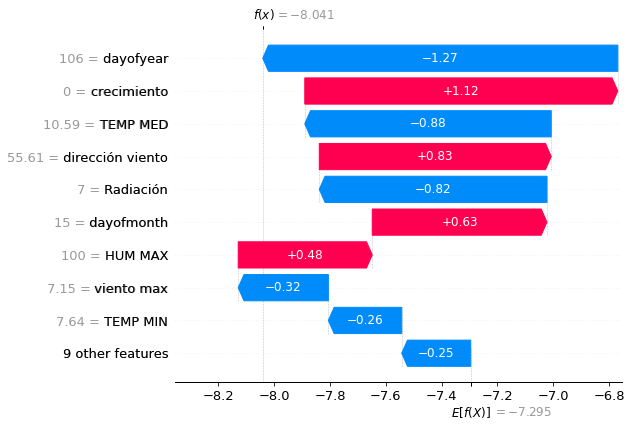

In [70]:
#Waterfall
print(index3)
shap.plots.waterfall(shap_values[index3])

### FORCE PLOT

In [71]:
shap.initjs()
expectedvalue=explainer.expected_value
shap.force_plot(expectedvalue,shap_values[index].values,link='logit')

In [72]:
shap.force_plot(expectedvalue,shap_values[index2].values,link='logit')

In [73]:
shap.force_plot(expectedvalue,shap_values[index3].values,link='logit')

### DECISION PLOT

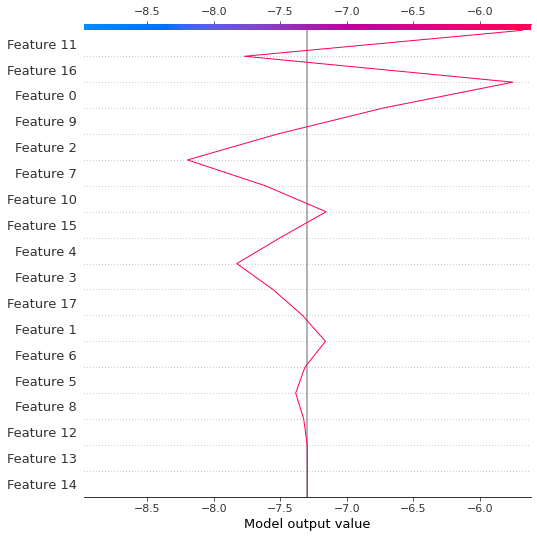

In [66]:
shap.decision_plot(expectedvalue,shap_values[index].values)

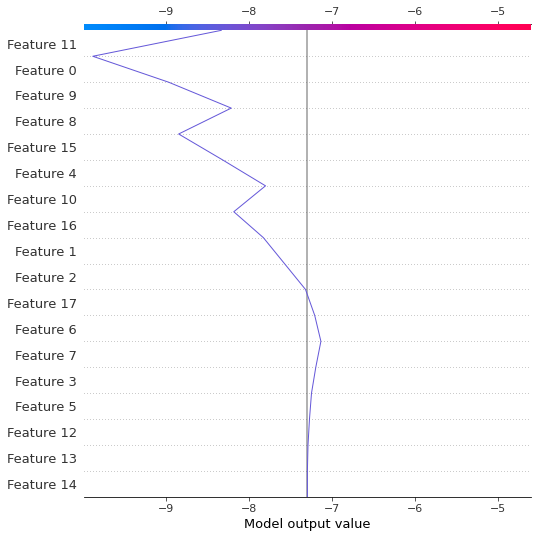

In [74]:
shap.decision_plot(expectedvalue,shap_values[index2].values)

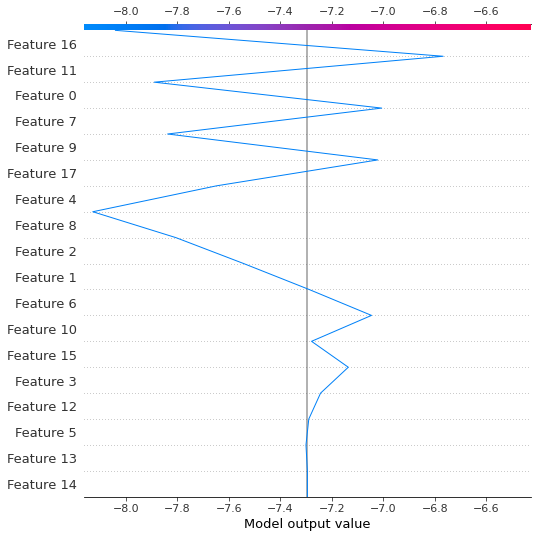

In [75]:
shap.decision_plot(expectedvalue,shap_values[index3].values)

## SUMMARY PLOT

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


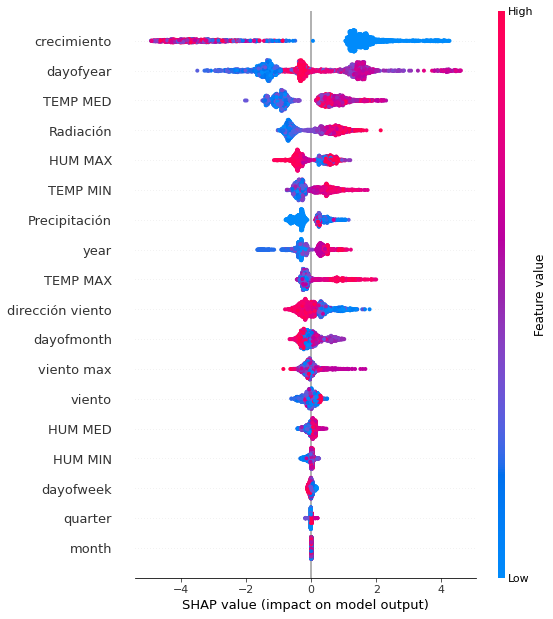

In [44]:
all_data= X_train.append(X_test)
shap_values=explainer(all_data)
shap.summary_plot(shap_values,all_data)

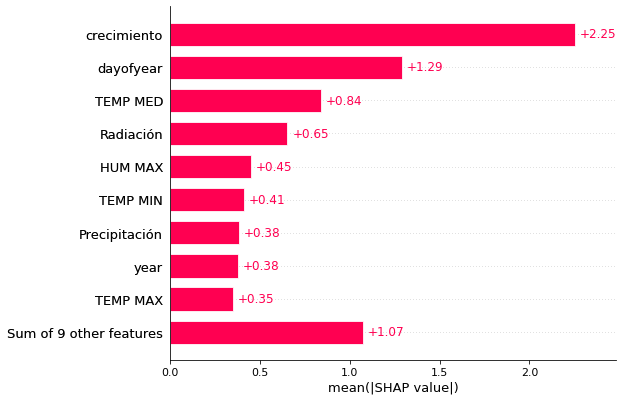

In [45]:
shap.plots.bar(shap_values)
#Las características se ordenan en sentido descendiente
#de importancia para la predicción.